In [ ]:
#Cell 1: Chuẩn bị các thư viện
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from google.colab import files
import os

# Mount Google Drive
drive.mount('/content/drive')

# Đọc dữ liệu từ Google Drive
df = pd.read_csv('/content/drive/My Drive/weather (1).csv', parse_dates=['date'])
print("Dữ liệu ban đầu:")
print(df.head())

Mounted at /content/drive
Dữ liệu ban đầu:
   province  max  min  wind wind_d  rain  humidi  cloud  pressure       date
0  Bac Lieu   27   22    17    NNE   6.9      90     71      1010 2009-01-01
1  Bac Lieu   31   25    20    ENE   0.0      64     24      1010 2010-01-01
2  Bac Lieu   29   24    14      E   0.0      75     45      1008 2011-01-01
3  Bac Lieu   30   24    30      E   0.0      79     52      1012 2012-01-01
4  Bac Lieu   31   25    20    ENE   0.0      70     24      1010 2013-01-01


Số lượng bản ghi của Hà Nội: 9098


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

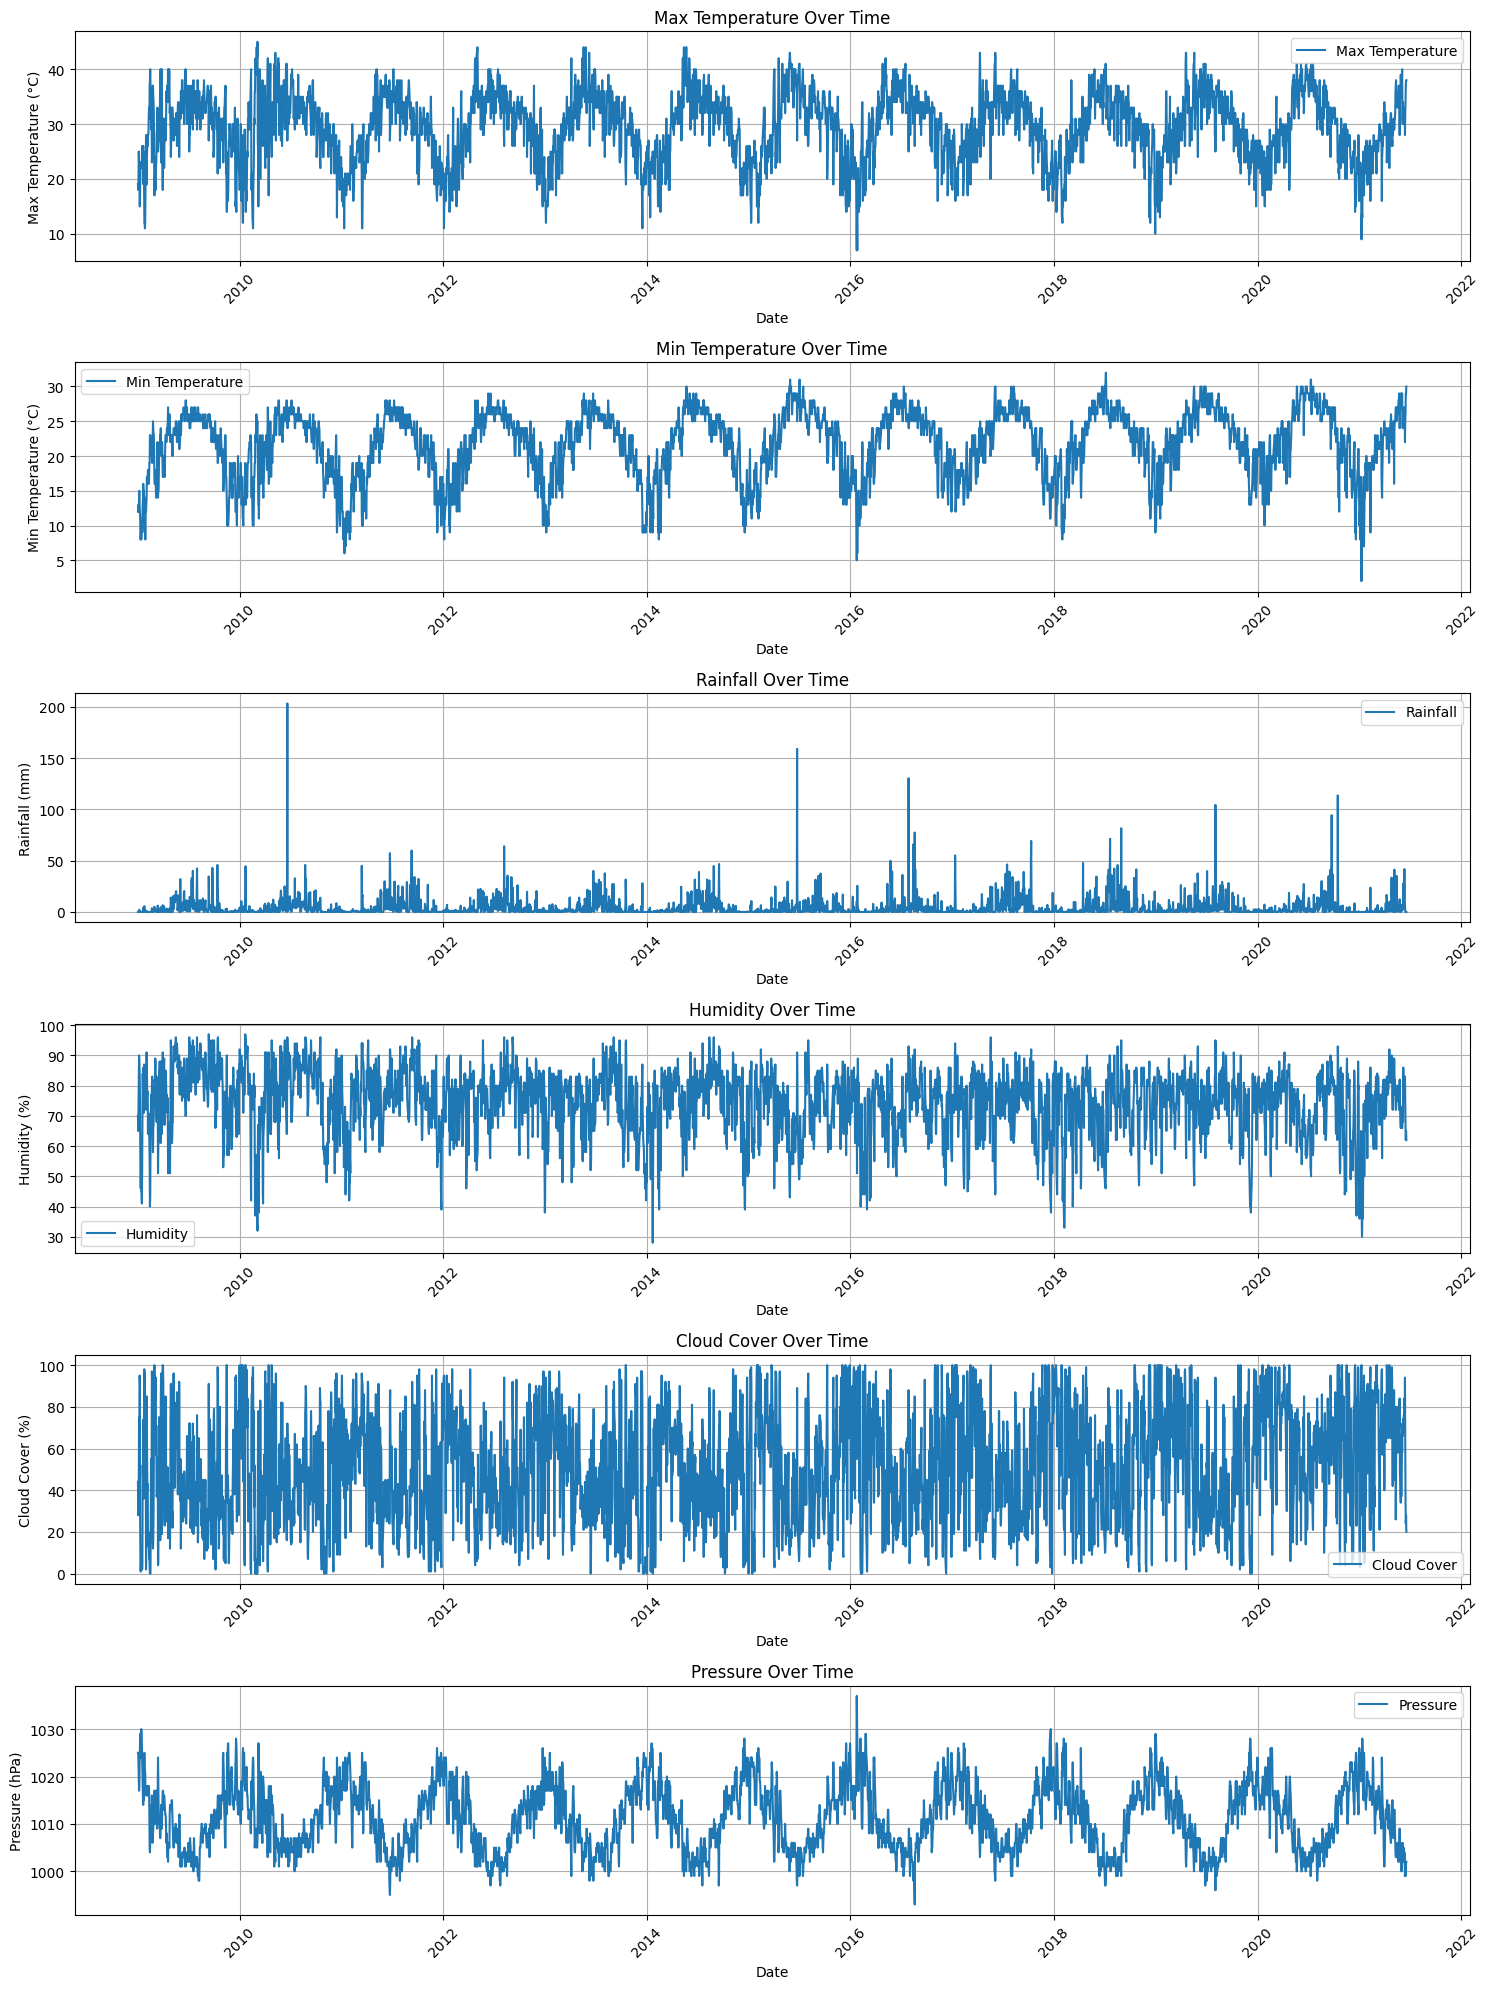

In [ ]:
# Lọc dữ liệu Hà Nội
df_hanoi = df[df['province'].str.lower().str.strip().isin(['ha noi', 'hanoi'])]
print(f"Số lượng bản ghi của Hà Nội: {len(df_hanoi)}")

# Loại bỏ cột không liên quan (bao gồm hướng gió 'wind_d')
columns_to_keep = ['date', 'max', 'min', 'rain', 'humidi', 'cloud', 'pressure']
df_hanoi_cleaned = df_hanoi[columns_to_keep]

# Xử lý giá trị thiếu
df_hanoi_cleaned = df_hanoi_cleaned.fillna({
    'max': df_hanoi_cleaned['max'].mean(),
    'min': df_hanoi_cleaned['min'].mean(),
    'rain': df_hanoi_cleaned['rain'].mean(),
    'humidi': df_hanoi_cleaned['humidi'].mean(),
    'cloud': df_hanoi_cleaned['cloud'].mean(),
    'pressure': df_hanoi_cleaned['pressure'].mean()
})

# Sắp xếp theo ngày
df_hanoi_cleaned = df_hanoi_cleaned.sort_values(by='date')

# Trực quan hóa từng loại dữ liệu
features = ['max', 'min', 'rain', 'humidi', 'cloud', 'pressure']
titles = ['Max Temperature', 'Min Temperature', 'Rainfall', 'Humidity', 'Cloud Cover', 'Pressure']
units = ['°C', '°C', 'mm', '%', '%', 'hPa']

plt.figure(figsize=(15, 20))
for i, (feature, title, unit) in enumerate(zip(features, titles, units), 1):
    plt.subplot(len(features), 1, i)
    plt.plot(df_hanoi_cleaned['date'], df_hanoi_cleaned[feature], label=title)
    plt.title(f'{title} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{title} ({unit})')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
plt.tight_layout()

# Lưu biểu đồ trực quan hóa
plt.savefig('/content/visualization_plots.png')
files.download('/content/visualization_plots.png')
plt.show()

In [ ]:
# Hàm tạo chuỗi tuần tự cho LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Chuẩn bị dữ liệu cho từng đặc trưng
seq_length = 60
features = ['max', 'min', 'rain', 'humidi', 'cloud', 'pressure']
data_dict = {}

for feature in features:
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df_hanoi_cleaned[feature].values.reshape(-1, 1))

    # Tạo chuỗi
    X, y = create_sequences(scaled_data, seq_length)

    # Chia tập huấn luyện, validation, và test (80% train, 10% valid, 10% test)
    train_size = int(len(X) * 0.8)
    valid_size = int(len(X) * 0.1)
    X_train, X_valid, X_test = X[:train_size], X[train_size:train_size + valid_size], X[train_size + valid_size:]
    y_train, y_valid, y_test = y[:train_size], y[train_size:train_size + valid_size], y[train_size + valid_size:]

    # Reshape cho LSTM [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Lưu vào dictionary
    data_dict[feature] = {
        'scaler': scaler,
        'X_train': X_train,
        'X_valid': X_valid,
        'X_test': X_test,
        'y_train': y_train,
        'y_valid': y_valid,
        'y_test': y_test,
        'scaled_data': scaled_data
    }

    # Làm phẳng X_train, X_valid, X_test để lưu (chuyển từ 3D về 2D)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # [samples, timesteps * features]
    X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Ghép X và y để lưu thành CSV (mỗi hàng là một chuỗi và giá trị mục tiêu)
    train_data = np.column_stack((X_train_flat, y_train))
    valid_data = np.column_stack((X_valid_flat, y_valid))
    test_data = np.column_stack((X_test_flat, y_test))

    # Lưu các tập dữ liệu thành CSV
    np.savetxt(f'train_{feature}.csv', train_data, delimiter=',')
    np.savetxt(f'valid_{feature}.csv', valid_data, delimiter=',')
    np.savetxt(f'test_{feature}.csv', test_data, delimiter=',')
    files.download(f'train_{feature}.csv')
    files.download(f'valid_{feature}.csv')
    files.download(f'test_{feature}.csv')

    print(f"\nFeature: {feature}")
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_valid:", X_valid.shape)
    print("Shape of X_test:", X_test.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: max
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: min
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: rain
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: humidi
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: cloud
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Feature: pressure
Shape of X_train: (7230, 60, 1)
Shape of X_valid: (903, 60, 1)
Shape of X_test: (905, 60, 1)



Training model for max...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 0.0310 - val_loss: 0.0082
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/50
226/226 ━━━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

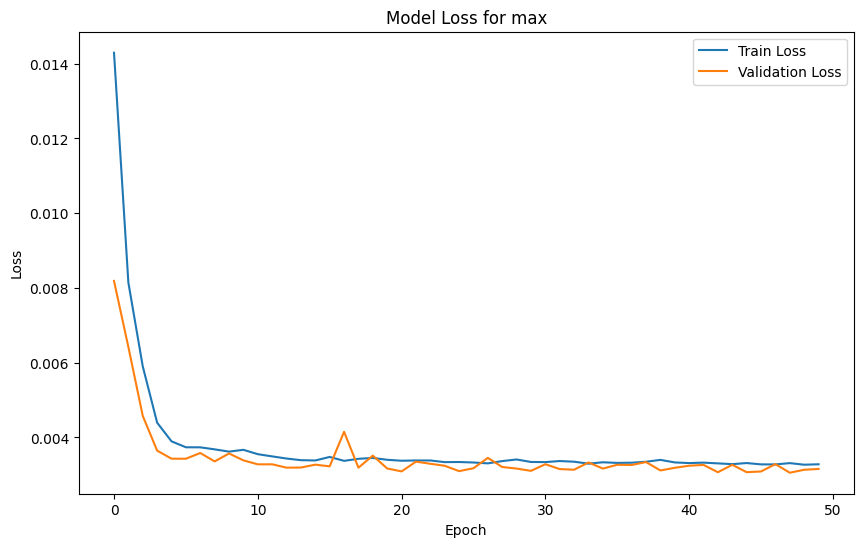


Training model for min...
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0459 - val_loss: 0.0055
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - loss: 0.0014 - val_loss: 0.0016
Epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

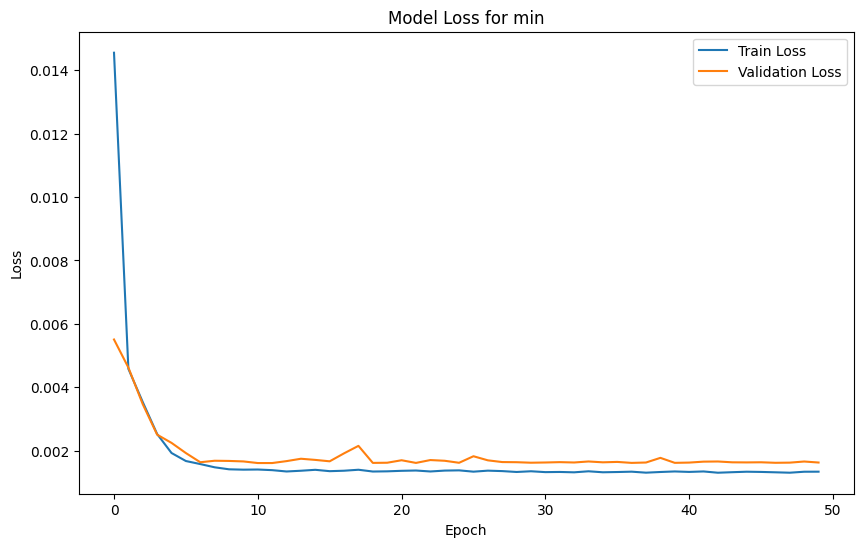


Training model for rain...
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0012 - val_loss: 8.1361e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0012 - val_loss: 6.9574e-04
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 8.9327e-04 - val_loss: 6.9162e-04
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 8.2503e-04 - val_loss: 7.3814e-04
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 7.6922e-04 - val_loss: 6.3769e-04
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 7.5982e-04 - val_loss: 6.3587e-04
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0010 - val_loss: 6.2422e-04
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 8.1373e-04 - val_loss: 6.1105e-04
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - loss: 6.6625e-04 - val_loss: 6.1108e-04
Epoch 11/50
226/226 ━━━━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

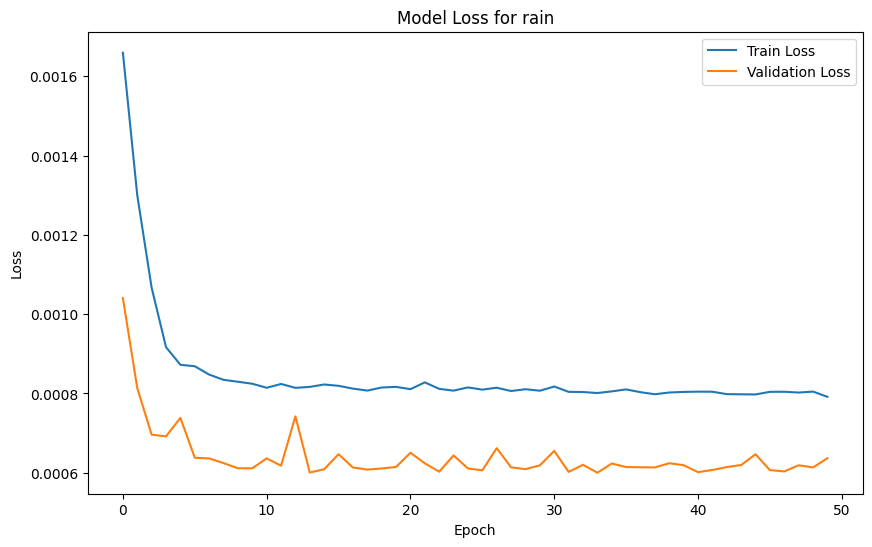


Training model for humidi...
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 0.0554 - val_loss: 0.0119
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0130 - val_loss: 0.0080
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0051 - val_loss: 0.0042


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

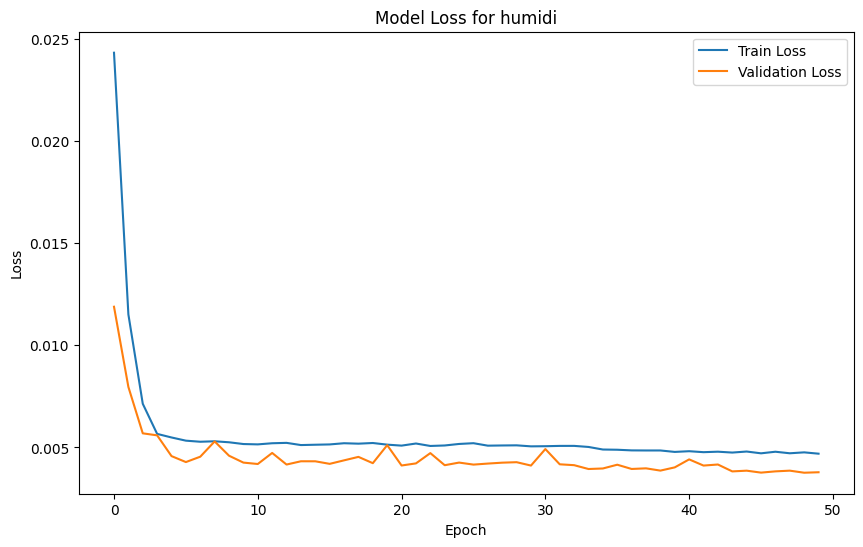


Training model for cloud...
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - loss: 0.0673 - val_loss: 0.0296
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0248 - val_loss: 0.0208
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0200 - val_loss: 0.0214
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - loss: 0.0187 - val_loss: 0.0186
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - loss: 0.0184 - val_loss: 0.0188
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0194 - val_loss: 0.0185
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0190 - val_loss: 0.0187
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.0188 - val_loss: 0.0188
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0190 - val_loss: 0.0175
E

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

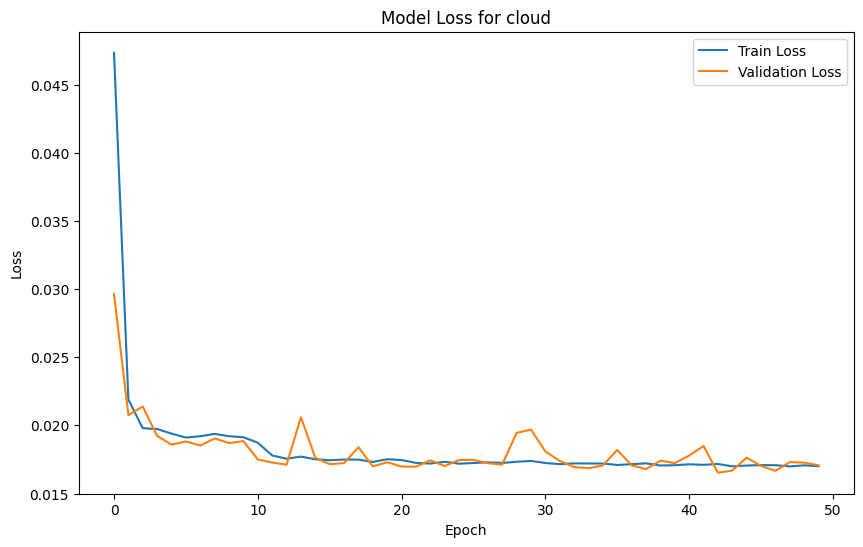


Training model for pressure...
Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 0.0248 - val_loss: 0.0043
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - loss: 0.0013 - val_loss: 9.9066e-04
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0012 - val_loss: 9.9471e-04
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0013 - val_loss: 9.9514e-04
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - loss: 0.0013 - val_loss: 9.7938e-04
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - loss: 0.0014 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

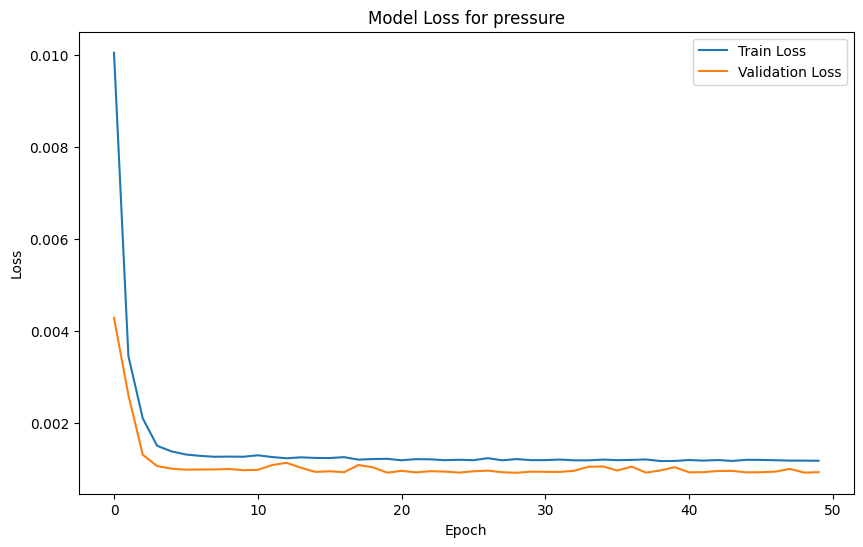

In [ ]:
# Dictionary để lưu mô hình
models = {}

# Huấn luyện mô hình cho từng đặc trưng
for feature in features:
    print(f"\nTraining model for {feature}...")

    # Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Lấy dữ liệu
    X_train = data_dict[feature]['X_train']
    y_train = data_dict[feature]['y_train']
    X_valid = data_dict[feature]['X_valid']
    y_valid = data_dict[feature]['y_valid']
    X_test = data_dict[feature]['X_test']
    y_test = data_dict[feature]['y_test']

    # Huấn luyện
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), verbose=1)

    # Lưu mô hình
    models[feature] = model

    # Vẽ và lưu biểu đồ mất mát
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss for {feature}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'loss_plot_{feature}.png')
    files.download(f'loss_plot_{feature}.png')
    plt.show()

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Evaluation for max (Thinned Data - Sampled every 10 points):
Train MAE: 2.20, Validation MAE: 2.27, Test MAE: 0.35
Train MSE: 9.12, Validation MSE: 9.72, Test MSE: 0.16
Train RMSE: 3.02, Validation RMSE: 3.12, Test RMSE: 0.40


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

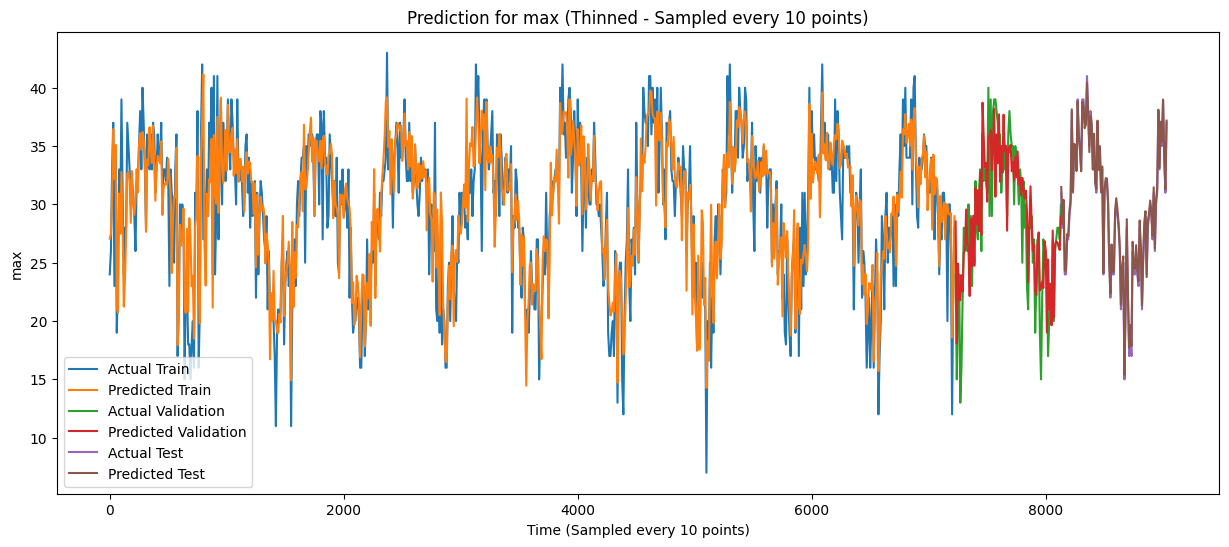

226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Evaluation for min (Thinned Data - Sampled every 10 points):
Train MAE: 1.07, Validation MAE: 1.21, Test MAE: 0.18
Train MSE: 2.12, Validation MSE: 3.34, Test MSE: 0.05
Train RMSE: 1.45, Validation RMSE: 1.83, Test RMSE: 0.22


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

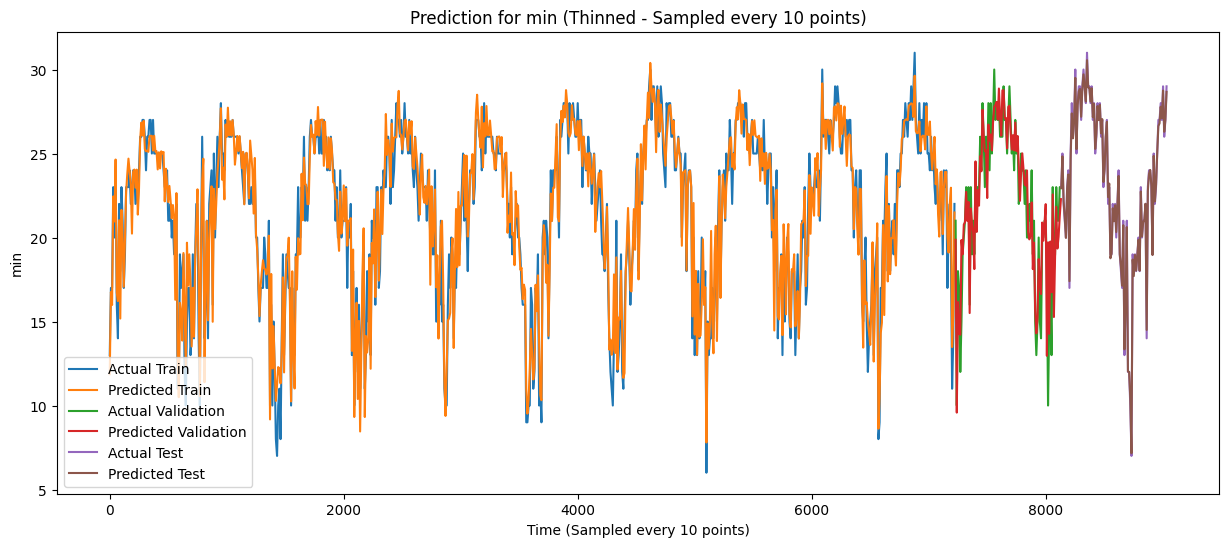

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Evaluation for rain (Thinned Data - Sampled every 10 points):
Train MAE: 4.32, Validation MAE: 4.28, Test MAE: 1.21
Train MSE: 56.75, Validation MSE: 50.61, Test MSE: 1.68
Train RMSE: 7.53, Validation RMSE: 7.11, Test RMSE: 1.30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

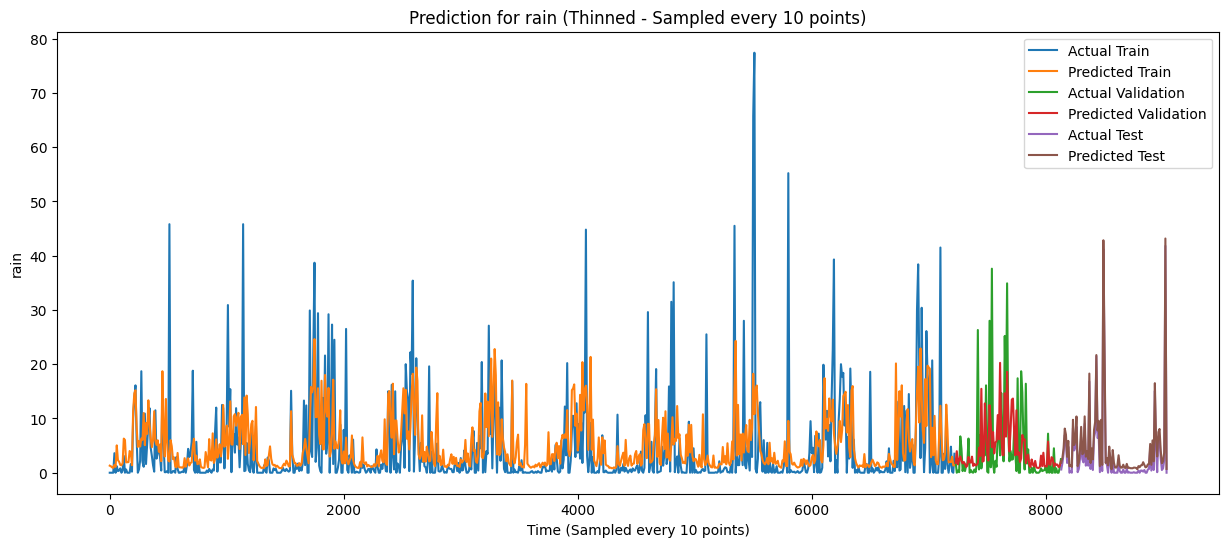

226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Evaluation for humidi (Thinned Data - Sampled every 10 points):
Train MAE: 5.13, Validation MAE: 5.21, Test MAE: 0.39
Train MSE: 46.78, Validation MSE: 46.22, Test MSE: 0.25
Train RMSE: 6.84, Validation RMSE: 6.80, Test RMSE: 0.50


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

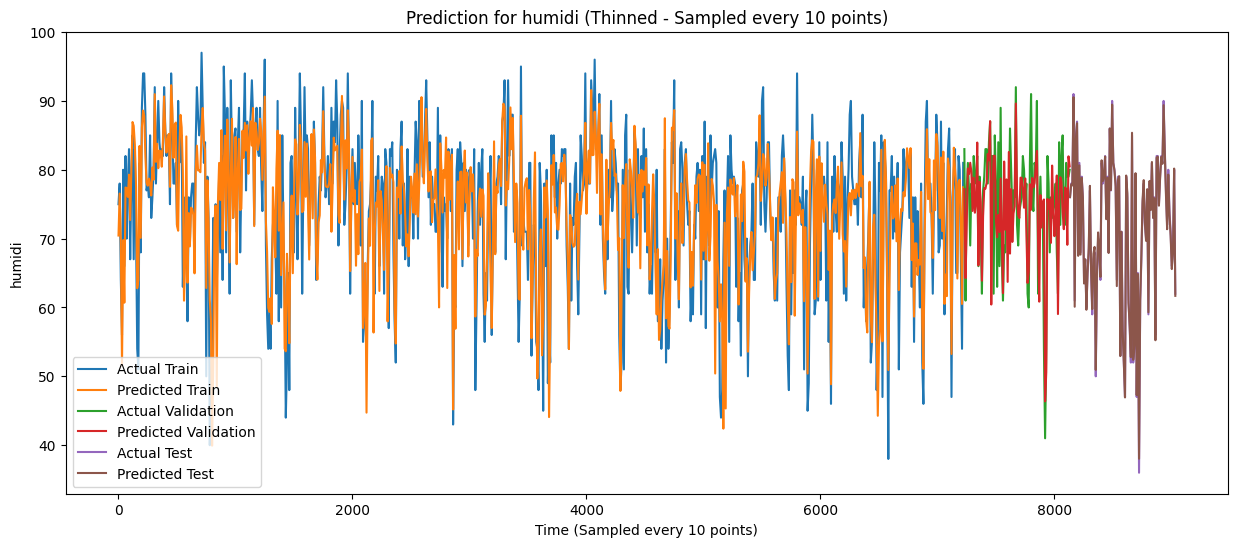

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Evaluation for cloud (Thinned Data - Sampled every 10 points):
Train MAE: 14.50, Validation MAE: 15.56, Test MAE: 2.41
Train MSE: 339.43, Validation MSE: 395.60, Test MSE: 8.18
Train RMSE: 18.42, Validation RMSE: 19.89, Test RMSE: 2.86


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

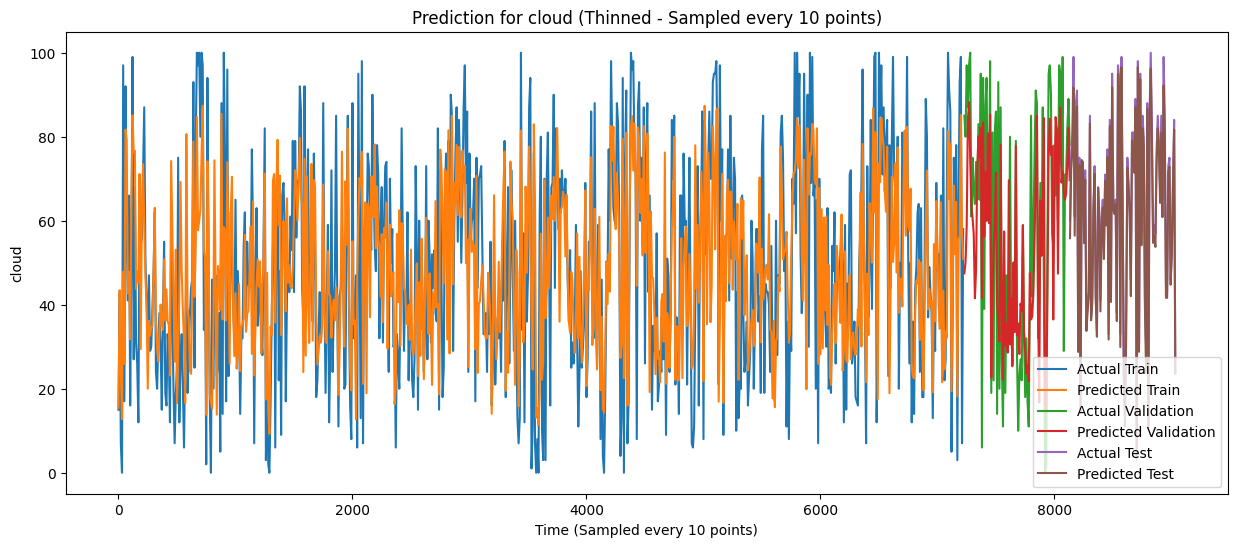

226/226 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Evaluation for pressure (Thinned Data - Sampled every 10 points):
Train MAE: 1.57, Validation MAE: 1.38, Test MAE: 0.27
Train MSE: 4.55, Validation MSE: 3.12, Test MSE: 0.13
Train RMSE: 2.13, Validation RMSE: 1.77, Test RMSE: 0.36


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

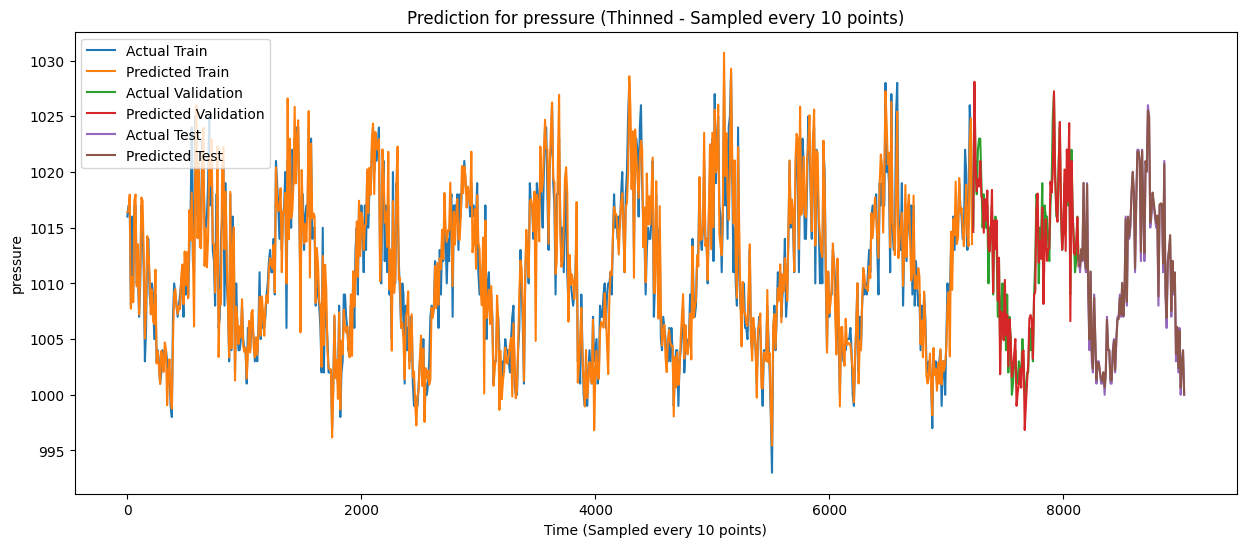

In [ ]:
# Đánh giá mô hình cho từng đặc trưng
for feature in features:
    model = models[feature]
    scaler = data_dict[feature]['scaler']
    X_train = data_dict[feature]['X_train']
    X_valid = data_dict[feature]['X_valid']
    X_test = data_dict[feature]['X_test']
    y_train = data_dict[feature]['y_train']
    y_valid = data_dict[feature]['y_valid']
    y_test = data_dict[feature]['y_test']

    # Dự đoán
    train_predict = model.predict(X_train)
    valid_predict = model.predict(X_valid)
    test_predict = model.predict(X_test)

    # Chuẩn hóa ngược
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform([y_train])
    valid_predict = scaler.inverse_transform(valid_predict)
    y_valid_inv = scaler.inverse_transform([y_valid])
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform([y_test])

    # Lấy mẫu mỏng hơn (mỗi 10 điểm) để giảm mật độ
    sample_step = 10
    train_indices = range(0, len(y_train_inv[0]), sample_step)
    valid_indices = range(len(y_train_inv[0]), len(y_train_inv[0]) + len(y_valid_inv[0]), sample_step)
    test_indices = range(len(y_train_inv[0]) + len(y_valid_inv[0]), len(y_train_inv[0]) + len(y_valid_inv[0]) + len(y_test_inv[0]), sample_step)
    train_predict_sampled = train_predict[::sample_step]
    valid_predict_sampled = valid_predict[::sample_step]
    test_predict_sampled = test_predict[::sample_step]
    y_train_inv_sampled = y_train_inv.T[::sample_step]
    y_valid_inv_sampled = y_valid_inv.T[::sample_step]
    y_test_inv_sampled = y_test_inv.T[::sample_step]

    # Tính MAE, MSE, RMSE trên dữ liệu mỏng hơn
    train_mae = np.mean(np.abs(train_predict_sampled - y_train_inv_sampled))
    valid_mae = np.mean(np.abs(valid_predict_sampled - y_valid_inv_sampled))
    test_mae = np.mean(np.abs(test_predict_sampled - y_test_inv_sampled))
    train_mse = np.mean((train_predict_sampled - y_train_inv_sampled) ** 2)
    valid_mse = np.mean((valid_predict_sampled - y_valid_inv_sampled) ** 2)
    test_mse = np.mean((test_predict_sampled - y_test_inv_sampled) ** 2)
    train_rmse = np.sqrt(train_mse)
    valid_rmse = np.sqrt(valid_mse)
    test_rmse = np.sqrt(test_mse)

    # In kết quả
    print(f"\nEvaluation for {feature} (Thinned Data - Sampled every 10 points):")
    print(f"Train MAE: {train_mae:.2f}, Validation MAE: {valid_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"Train MSE: {train_mse:.2f}, Validation MSE: {valid_mse:.2f}, Test MSE: {test_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}, Validation RMSE: {valid_rmse:.2f}, Test RMSE: {test_rmse:.2f}")

    # Vẽ và lưu biểu đồ với dữ liệu mỏng hơn
    plt.figure(figsize=(15, 6))
    plt.plot(train_indices, y_train_inv_sampled, label='Actual Train')
    plt.plot(train_indices, train_predict_sampled, label='Predicted Train')
    plt.plot(valid_indices, y_valid_inv_sampled, label='Actual Validation')
    plt.plot(valid_indices, valid_predict_sampled, label='Predicted Validation')
    plt.plot(test_indices, y_test_inv_sampled, label='Actual Test')
    plt.plot(test_indices, test_predict_sampled, label='Predicted Test')
    plt.title(f'Prediction for {feature} (Thinned - Sampled every 10 points)')
    plt.xlabel('Time (Sampled every 10 points)')
    plt.ylabel(feature)
    plt.legend()
    plt.savefig(f'prediction_plot_{feature}.png')
    files.download(f'prediction_plot_{feature}.png')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

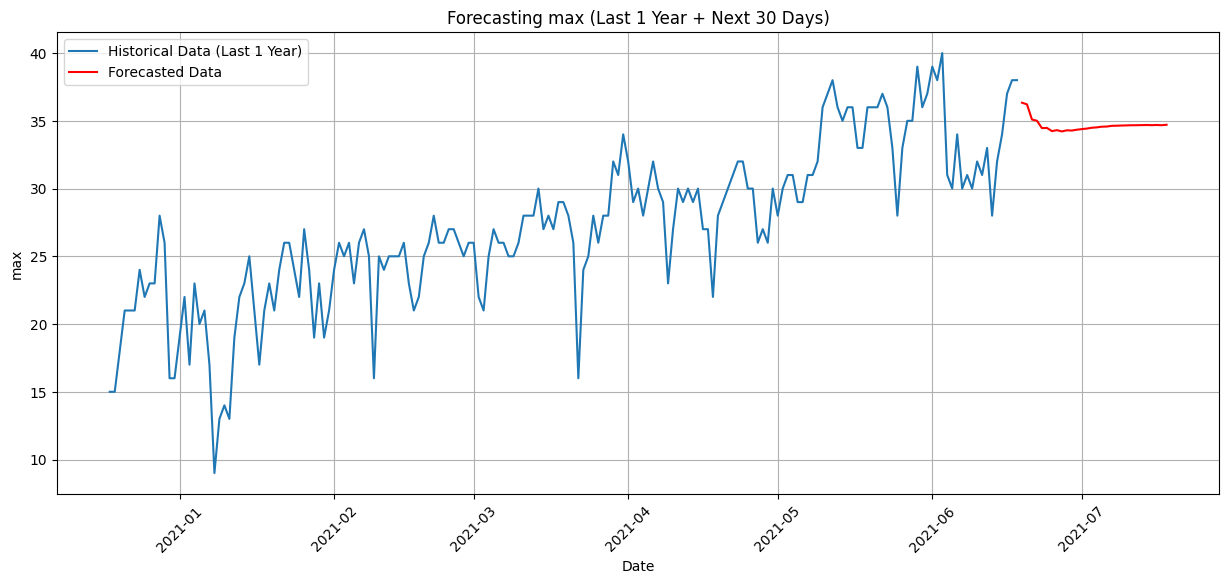

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

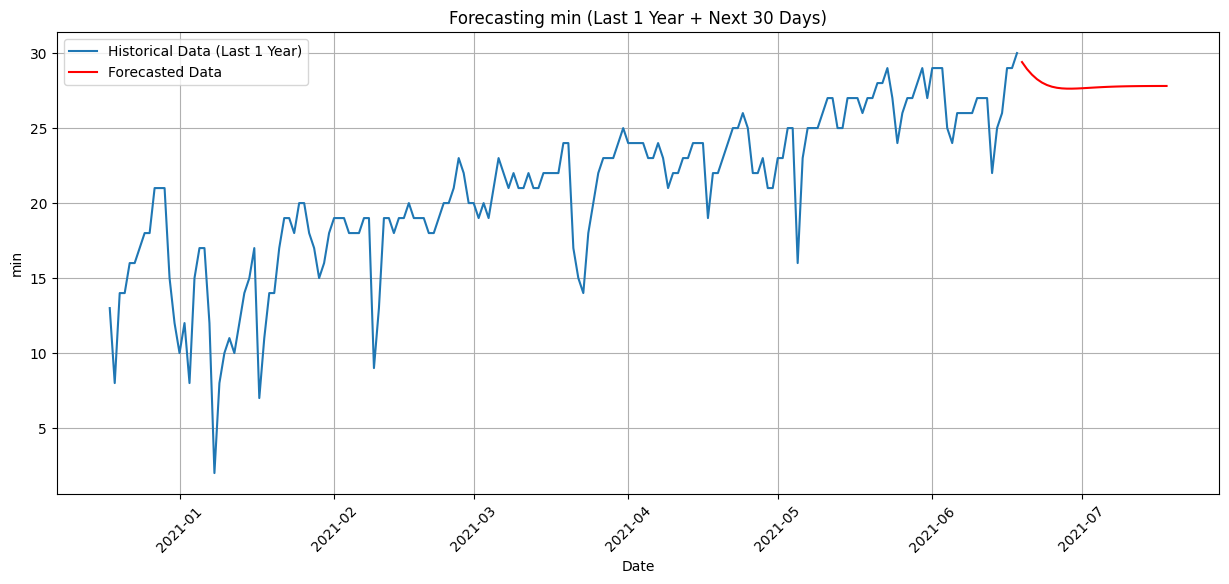

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

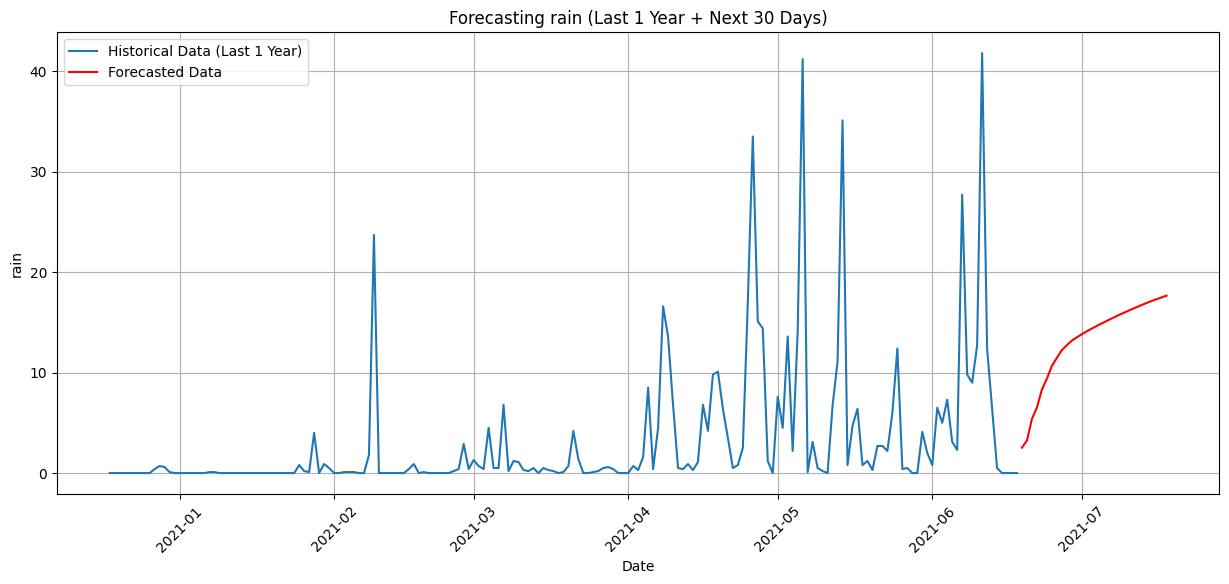

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

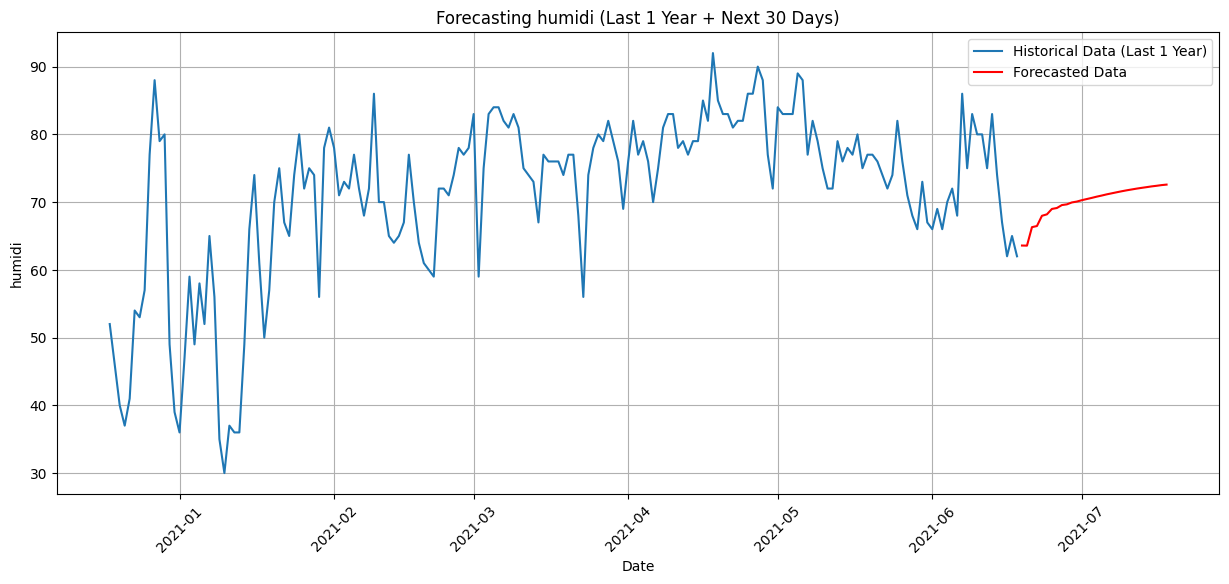

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

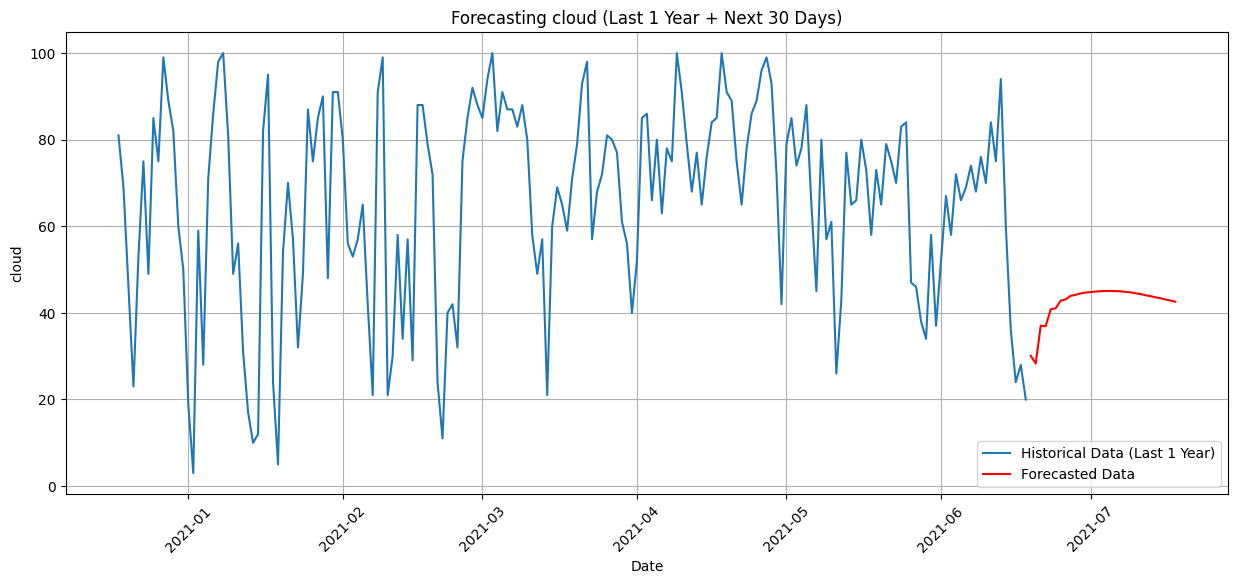

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

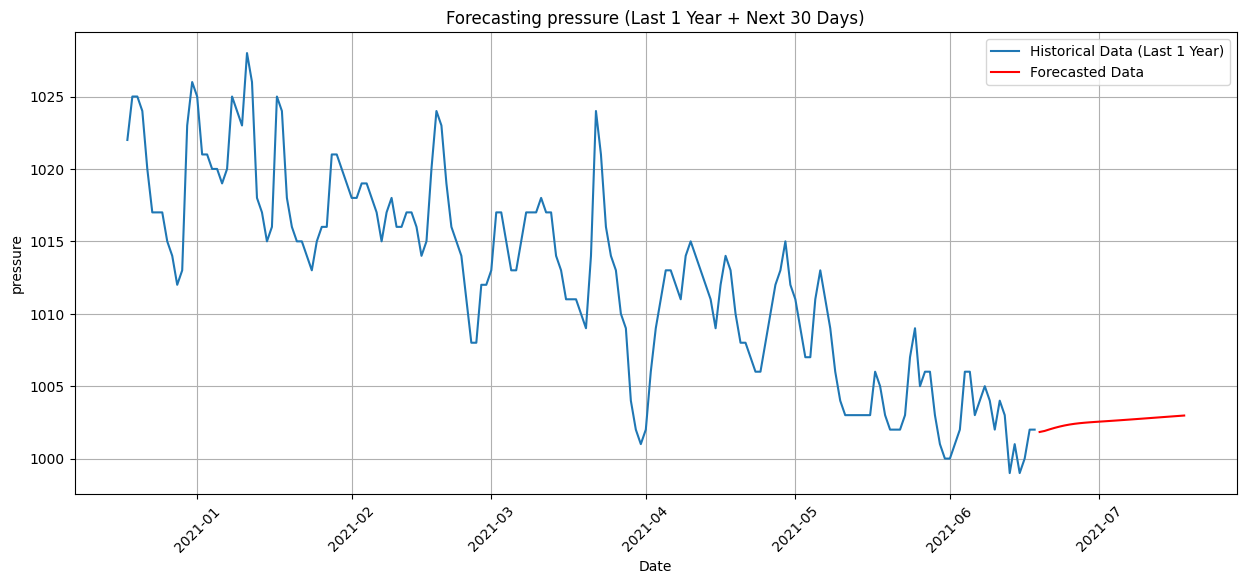

In [ ]:
# Dự báo 30 ngày tiếp theo cho từng đặc trưng
for feature in features:
    model = models[feature]
    scaler = data_dict[feature]['scaler']
    scaled_data = data_dict[feature]['scaled_data']

    # Dự báo
    last_sequence = scaled_data[-seq_length:]
    future_predictions = []

    for _ in range(30):
        next_pred = model.predict(last_sequence.reshape(1, seq_length, 1))
        future_predictions.append(next_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_pred[0, 0]

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Lấy dữ liệu 1 năm trước đó (365 ngày cuối)
    one_year_ago_idx = max(0, len(df_hanoi_cleaned) - 365)
    historical_dates = df_hanoi_cleaned['date'].iloc[one_year_ago_idx:]
    historical_data = scaler.inverse_transform(scaled_data[one_year_ago_idx:])

    # Tạo mảng ngày cho 30 ngày tiếp theo
    last_date = df_hanoi_cleaned['date'].iloc[-1]
    future_dates = pd.date_range(start=last_date, periods=31, freq='D')[1:]

    # Vẽ và lưu biểu đồ với dữ liệu lịch sử 1 năm và dự báo 30 ngày
    plt.figure(figsize=(15, 6))
    plt.plot(historical_dates, historical_data, label='Historical Data (Last 1 Year)')
    plt.plot(future_dates, future_predictions, label='Forecasted Data', color='red')
    plt.title(f'Forecasting {feature} (Last 1 Year + Next 30 Days)')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'forecast_plot_{feature}.png')
    files.download(f'forecast_plot_{feature}.png')
    plt.show()